In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import sys
dir_string = 'C:/Users/rannu/OneDrive - NTNU/Desktop/VsPython/'+\
                'Spain/NMfDS/Assignments/'
sys.path.append(dir_string + 'Ass4')
sys.path.append(dir_string + 'Ass6')
sys.path.append(dir_string + 'Ass7')
sys.path.append(dir_string + 'Ass8')
sys.path.append(dir_string + 'Ass9')
from RTBP_definitions import r1, r2, OMEGA, ODE_R3BP, Jacobi_first_integral
from Lagrange_computations import compute_Lagrange_pt, compute_jacobi_const_Li
from custom_ODE_solver import ODE_solver
from PoincareR3BP import poincare_map_solve_ivp_R3BP
from variational_equation_RTBP import variational_eq
from crossings_RTBP import crossings_R3BP_by_mu

In [3]:

def bisection_old(f, start, end, tol, N):
    """
    Input: function f, interval [start, end], tolerance tol, 
    max. number of iterations N

    Output: approximate solution mid
    """
    # Check if f(start) and f(end) have opposite signs
    if f(start)*f(end) >= 0:
        print("\nBisection method fails.")
        print("f(start) = ", f(start))
        print("f(end) = ", f(end))
        return None
    # Iterate until max. number of iterations is reached
    for i in range(N):
        # Compute midpoint
        mid = (start+end)/2
        # Check if f(mid) is zero
        if f(mid) == 0:
            break
        # Check if f(start) and f(mid) have opposite signs
        if f(start)*f(mid) < 0:
            end = mid
        # Otherwise, f(end) and f(mid) have opposite signs
        else:
            start = mid
        # Check if the interval is small enough
        if (end-start)/2 < tol:
            break
        if i == N-1:
            print("\nWarning: maximum number of iterations reached.")
    return mid

In [4]:
# Test scipy.optimize.bisect
def f(x):
    return x**2 - 2
print("Scipy bisection: ", bisect(f, 1, 2, xtol=1e-16, maxiter=200))
print("Exact solution:  ", np.sqrt(2))
print("Error:           ", np.abs(bisect(f, 1, 2, xtol=1e-10, maxiter=100)\
                                  -np.sqrt(2)))

Scipy bisection:  1.414213562373095
Exact solution:   1.4142135623730951
Error:            4.705502654189786e-11


In [5]:
# HINT: it should work with
# mu=0.1, cmin=2.1 cmax=3.189, xincC=1.d-3, xincini=1.d-5, xincx=1.d-3

In [6]:
mu = 0.1
print(compute_Lagrange_pt(mu, 3))
L3 = [compute_Lagrange_pt(mu, 3), 0, 0, 0]
L3.extend([1, 0, 0, 0, 
           0, 1, 0, 0, 
           0, 0, 1, 0, 
           0, 0, 0, 1])  # initial conditions and identity matrix
time_span = 0

# compute the Jacobian matrix of the RTBP at Li.
# The eigenvalues of this matrix are the frequencies of the periodic orbit

A = variational_eq(time_span, L3, mu, 1)[4:20].reshape(4,4)
print('det(A) = \n', A)
eigenvalues, eigenvectors = np.linalg.eig(A)
lambda_pos = eigenvalues[3].real
lambda_neg = eigenvalues[2].real
eigvec_pos = eigenvectors[:,3]
eigvec_neg = eigenvectors[:,2]
print('\neigenvalues = \n', lambda_pos, ",", lambda_neg)
print('\nTheir respective normalized eigenvectors = \n', -eigvec_pos.real, \
      ",\n", eigvec_neg.real)
# Only the real part of the eigenvectors are needed

1.0416089085718845
det(A) = 
 [[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 3.18338396  0.          0.          2.        ]
 [ 0.         -0.09169198 -2.          0.        ]]

eigenvalues = 
 0.5016383507584008 , -0.5016383507584007

Their respective normalized eigenvectors = 
 [ 0.28940578 -0.84569227  0.14517704 -0.42423167] ,
 [-0.28940578 -0.84569227  0.14517704  0.42423167]


In [7]:
# Assume C fixed. Implement a routine such that, given an initial x,
# sign of y’ and C, computes (as output) y’, such that the initial condition
# of the orbit will be (x,0,0,y’).
                      
# def Jacobi_first_integral(mu, x, y, vx, vy):
#     # Function to compute the Jacobi first integral
#     # This should be constant for a given value of mu
#     return 2*OMEGA(mu, x, y) - (vx**2 + vy**2)

def yderiv(mu, x, y, vx, sign_vy, C):
    # Function to compute the derivative of y for a given value of C
    return sign_vy*np.sqrt(2*OMEGA(mu, x, y) - C - vx**2)

C = Jacobi_first_integral(mu, L3[0], L3[1], L3[2], L3[3])

vy = yderiv(mu, L3[0], L3[1], L3[2], 1, C)

print('\nC = ', C)
print('\nvy = ', vy)


C =  3.1895781504493814

vy =  0.0


In [8]:
def F_old(x, vy):
    init_cond = [x, 0, 0, vy]
    # Find the crossing time of the unstable manifold with the Poincare section
    iregion = 1
    t0 = 0
    tmax = 0.15
    dt = 0.1
    t_span = np.arange(t0, tmax, dt)

    # Variables for tweaking the accuracy of the crossing time
    refinement = 20000
    refinement_fine = 300
    tol = 1e-14

    newInitial, TimeDuration,_ = \
        poincare_map_solve_ivp_R3BP(lambda t, X: ODE_R3BP(t, mu, X), 
                                    init_cond, 
                                    iregion, dt, t_span, mu, 
                                    init_search = refinement, 
                                    refinement = refinement_fine, 
                                    newton_tol = tol)

    tmax_plot = TimeDuration
    t_span_plot = np.arange(t0, tmax_plot, 0.01)

    # Solve ode_r3bp using the custom ODE solver,  RETURNS: the solution of the 
    # system of ODEs as a scipy.integrate.solve_ivp object
    sol = ODE_solver(lambda t, X: ODE_R3BP(t, mu, X), init_cond, tmax_plot, 
                    len(t_span_plot), tol=1e-12, method='DOP853', hamiltonian=0)

    # Extract the solution
    x = sol.y[0]
    y = sol.y[1]
    vx = sol.y[2]
    vy = sol.y[3]
    return x, y, vx, vy, t_span_plot, newInitial, TimeDuration

In [9]:
# Assume C fixed. Implement a routine such that given an initial x
# and the ’associated’ initial condition (x,0,0,y’), returns as
# output F(x)=x’ (at a given crossing).
def F(x, C):
    vy = yderiv(mu, x, 0, 0, -1, C)
    init_cond = [x, 0, 0, vy]

    iregion = 1
    t0 = 0
    tmax = 1
    dt = 0.5
    t_span = np.arange(t0, tmax, dt)

    # Variables for tweaking the accuracy of the crossing time
    refinement = 2000
    refinement_fine = 300
    tol = 1e-3

    newInitial, TimeDuration,_ = \
        poincare_map_solve_ivp_R3BP(lambda t, X: ODE_R3BP(t, mu, X), 
                                    init_cond, 
                                    iregion, dt, t_span, mu, 
                                    init_search = refinement, 
                                    refinement = refinement_fine, 
                                    newton_tol = tol)
    
    return newInitial[2] #x'

In [10]:
# Define a functiont that varies x such that you find x1 and x2 such that F(x,C)
# changes sign.

def F_rough_search(x0, x_inc, C):
    # Function to compute the x value where F(x,C) changes sign
    # x0 is the initial guess for the root
    # x_inc is the increment we add to x used to compute the derivative of F(x,C)
    # C is the Jacobi constant
    x1 = x0
    x2 = x0 + x_inc
    F1 = F(x1, C)
    F2 = F(x2, C)
    while F1*F2 > 0:
        x1 = x2
        x2 += x_inc
        F1 = F2
        F2 = F(x2, C)
    return x1, x2

In [11]:
# Now refine x, using scipy bisection, such that F(x)=0.
# (ie |F(x)|<1.d-12)

def F_refine_bisection(x1, x2, C):
    # Function to refine the root of F(x,C) using scipy bisection
    # x1 and x2 are the x values where F(x,C) changes sign
    # C is the Jacobi constant
    return bisect(lambda x: F(x, C), x1, x2, xtol=1e-6, maxiter=10)

### Using our functions

In [12]:
# HINT: it should work with
# mu=0.1, cmin=2.1 cmax=3.189, xincC=1.d-3, xincini=1.d-5, xincx=1.d-3
mu = 0.1
cmin = 2.5
cmax = 3.189
xincC = 1e-3 
xincini = 1e-5
xincx = 1e-3

# Find the first root of F(x,C) for C = cmin
x_L3 = compute_Lagrange_pt(mu, 3)
x_0 = x_L3 + 1e-5
x_0 = 1.57
print('x_L3 = ', x_L3)
print('x_0 = ', x_0)


C = cmax
C = 2.5
x1, x2 = F_rough_search(x_0, xincx, C)
print('x1 = ', x1, ', x2 = ', x2)



x_L3 =  1.0416089085718845
x_0 =  1.57


x1 =  1.669999999999989 , x2 =  1.670999999999989


In [13]:
# use bisect to refine the root
x_root = F_refine_bisection(x1, x2, C)

In [14]:
print('x_root = ', x_root)
# root - x1
print('root - x1 = ', x_root - x1)
# root - x2
print('root - x2 = ', x_root - x2)

x_root =  1.670213867187489
root - x1 =  0.00021386718750004974
root - x2 =  -0.0007861328124998401


[ 3.81416777e-01  2.91433544e-16 -1.17502683e-03  2.07069114e+00]


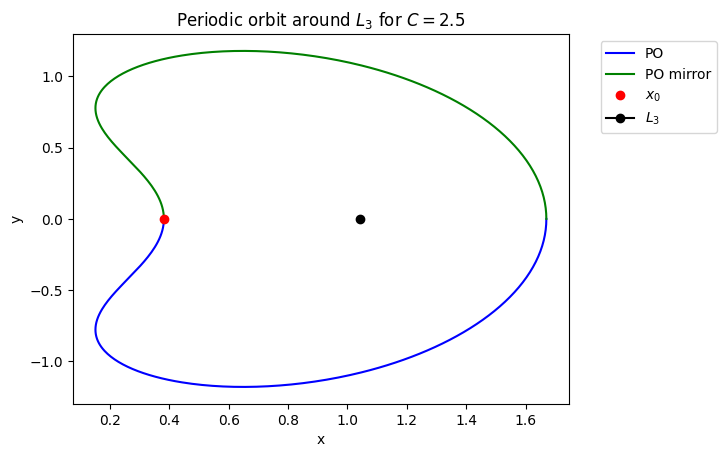

In [15]:
vy = yderiv(mu, x_root, 0, 0, -1, C)
x, y, vx, vy, t_span_plot, newInitial, TimeDuration = F_old(x_root, vy)

print(newInitial)

# Plot the orbit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, 'b')
ax.plot(x, -y, 'g')
ax.plot(newInitial[0], newInitial[1], 'ro')
ax.plot(x_L3, 0, color = 'black', marker = 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Periodic orbit around $L_3$ for $C = {C}$')
# make a legend
legend = [r'PO', r'PO mirror', r'$x_0$', r'$L_3$']
#plot the legend outside of the plot
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Plot 3 at once

In [64]:
print(C_lst[1]-C_lst[0], C_lst[2]-C_lst[1], C_lst[3]-C_lst[2], C_lst[4]-C_lst[3])

-0.007153846153848509 -0.007153846153848509 -0.007153846153848065 -0.007153846153848509


In [56]:
# for the following three values of C, compute the x value of the root of F(x,C)
# and the period of the periodic orbit around L3
#C=2.1,2.5,3.15
#x0 = 1.789, 1.73, 1.25
from tqdm import tqdm
mu = 0.1
xincx = 1e-3 
All_C_vals = np.arange(3.189, 2.1, -1e-3)
print(All_C_vals[810])
C_lst = np.flip(np.linspace(2.1, All_C_vals[810], 40))
x0 = 1.7
x_roots = []

for i in tqdm(range(len(C_lst))):
    mu = 0.1
    cmin = 2.1
    cmax = 3.189
    xincC = 1e-3 
    xincini = 1e-5
    xincx = 1e-3
    C = C_lst[i]
    #x0 = x0_lst[i]
    x1, x2 = F_rough_search(x0, xincx, C)
    x_roots.append(F_refine_bisection(x1, x2, C))

np.save('x_vals_last_part', x_roots)
np.save('C_vals_last_part', C_lst)

2.3790000000000893


100%|██████████| 40/40 [05:39<00:00,  8.49s/it]

x_root =  [1.717032226562498, 1.7196455078124977, 1.7222412109374974, 1.724819335937497, 1.7273818359374968, 1.7299287109374963, 1.7324580078124965, 1.7349736328124958, 1.7374716796874958, 1.7399541015624955, 1.7424208984374951, 1.7449892578124948, 1.7473173828124948, 1.7497314453124944, 1.7521416015624942, 1.7545361328124938, 1.7569169921874934, 1.7592822265624934, 1.761631835937493, 1.7639638671874929, 1.7662802734374927, 1.7685751953124924, 1.770848632812492, 1.7730966796874919, 1.7753115234374917, 1.7774892578124915, 1.7796181640624913, 1.7816865234374908, 1.7836748046874906, 1.7855576171874905, 1.7872978515624904, 1.78884863281249, 1.7901318359374898, 1.7910458984374897, 1.7914345703124899, 1.7969482421874892, 1.8020283203124887, 1.8041650390624884, 1.8062939453124882, 1.808415039062488]


In [57]:
# for the three roots, calc vy and use F_old
vys = []
for i in range(len(C_lst)):
    vys.append(yderiv(mu, x_roots[i], 0, 0, -1, C_lst[i]))

x3 = []
y3 = []
vx3 = []
vy3 = []
t_span_plot3 = []
newInitial3 = []
TimeDuration3 = []

for i in tqdm(range(len(C_lst))):
    x_0 = x_roots[i]
    C = C_lst[i]
    x_temp, y_temp, vx_temp, vy_temp, t_span_plot_temp, newInitial_temp, \
        TimeDuration_temp = F_old(x_roots[i], vys[i])
    x3.append(x_temp)
    y3.append(y_temp)
    vx3.append(vx_temp)
    vy3.append(vy_temp)
    t_span_plot3.append(t_span_plot_temp)
    newInitial3.append(newInitial_temp)
    TimeDuration3.append(TimeDuration_temp)

[]


100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


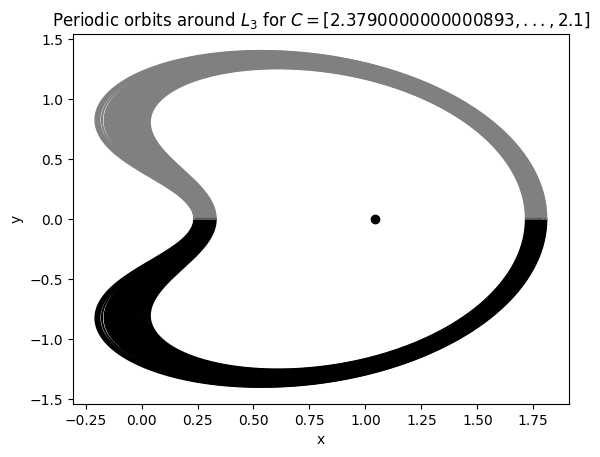

In [58]:
# plot the orbits
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(C_lst)):
    ax.plot(x3[i], y3[i], color = 'black')
    ax.plot(x3[i], -y3[i], color = 'grey')
ax.plot(x_L3, 0, color = 'black', marker = 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Periodic orbits around $L_3$ for $C = [{C_lst[0]},...,{C_lst[len(C_lst)-1]}]$')

plt.show()

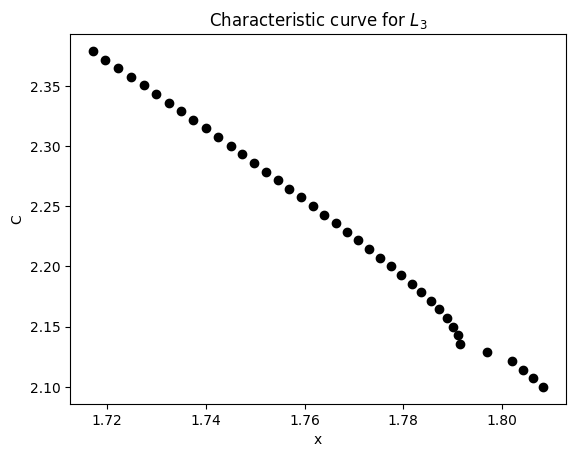

In [59]:
# plot the characteristic curve as a scatterplot
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(C_lst)):
    ax.scatter(x_roots[i], C_lst[i], color = 'black')
ax.set_xlabel('x')
ax.set_ylabel('C')
ax.set_title(f'Characteristic curve for $L_3$')
plt.show()

In [60]:
loaded_arr_x_vals_first_800 = np.load('x_vals_first_800.npy')
loaded_arr_x_vals_last_part = np.load('x_vals_last_part.npy')
loaded_arr_C_vals_last_part = np.load('C_vals_last_part.npy')
loaded_C_vals = np.load('C_vals.npy')
print(loaded_arr_x_vals_first_800)
print(loaded_arr_x_vals_last_part[0])
print(loaded_arr_C_vals_last_part[0])
print(loaded_C_vals[0])

[1.04604578 1.07365223 1.08254774 ... 0.         0.         0.        ]
1.717032226562498
2.3790000000000893
3.189


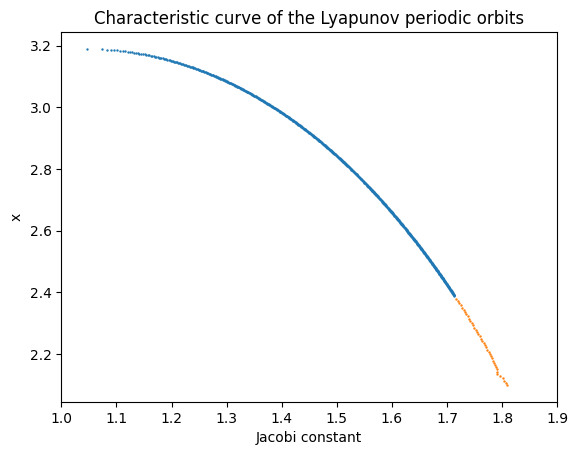

In [62]:
# plot the characteristic curve as a scatterplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(loaded_arr_x_vals_first_800, loaded_C_vals, s=0.5)
ax.scatter(loaded_arr_x_vals_last_part, loaded_arr_C_vals_last_part, s=0.5)
ax.set_xlabel('Jacobi constant')
ax.set_ylabel('x')
ax.set_title('Characteristic curve of the Lyapunov periodic orbits')
ax.set_xlim(1, 1.9)
plt.show()

In [142]:
print(loaded_arr_x_vals_first_800[800])

1.713352424196788


In [145]:
def characteristic_curve_last_200():
    mu = 0.1
    cmin = 2.1
    cmax = 3.189
    xincC = 1e-3
    xincx = 1e-3
    C_vals = np.arange(cmax, cmin, -xincC)
    x_vals = np.zeros(len(C_vals))
    print('C_vals = ', C_vals, 'number of C values = ', len(C_vals))
    # first initial search for the root

    x_0 = loaded_arr_x_vals_first_800[800]
    
    x1, x2 = F_rough_search(x_0, xincx, C_vals[801])
    x_root = F_refine_bisection(x1, x2, C_vals[801])
    x_vals[801] = x_root
    print("initial search done")
    # now loop over the rest of the C values
    for i in tqdm(range(802, len(C_vals))):
        x1, x2 = F_rough_search(x_vals[i-1], xincx, C_vals[i])
        print('x1, x2: ', x1, x2, 'C = ', C_vals[i], 'i = ', i)
        x_root = F_refine_bisection(x1, x2, C_vals[i])
        x_vals[i] = x_root
    # testloop
    # for j in tqdm(range(1, 10)):
    #     i = 100*j
    #     print("x_vals[i-100]:",x_vals[i-100])
    #     x1, x2 = F_rough_search(x_vals[i-100], xincx, C_vals[i])
    #     print('x1, x2: ', x1, x2, 'C = ', C_vals[i], 'i = ', i, 'j = ', j)
    #     x_root = F_refine_bisection(x1, x2, C_vals[i])
    #     print('the root', x_root)
    #     x_vals[i] = x_root

    return C_vals, x_vals

C_vals_end, x_vals_end = characteristic_curve_last_200()
print(C_vals)
print(x_vals)

C_vals =  [3.189 3.188 3.187 ... 2.103 2.102 2.101] number of C values =  1089
initial search done


  0%|          | 0/287 [00:00<?, ?it/s]

x1, x2:  1.7137205882592879 1.7147205882592877 C =  2.3870000000000884 i =  802


  0%|          | 1/287 [00:00<03:29,  1.36it/s]

x1, x2:  1.7140907054467878 1.7150907054467877 C =  2.3860000000000885 i =  803


  1%|          | 2/287 [00:01<03:28,  1.37it/s]

x1, x2:  1.7144588695092877 1.7154588695092876 C =  2.3850000000000886 i =  804


  1%|          | 3/287 [00:02<03:25,  1.38it/s]

x1, x2:  1.7148289866967876 1.7158289866967875 C =  2.3840000000000887 i =  805


  1%|▏         | 4/287 [00:02<03:23,  1.39it/s]

x1, x2:  1.7151971507592876 1.7161971507592875 C =  2.383000000000089 i =  806


  2%|▏         | 5/287 [00:03<03:22,  1.39it/s]

x1, x2:  1.7155633616967874 1.7165633616967872 C =  2.382000000000089 i =  807


  2%|▏         | 6/287 [00:04<03:24,  1.37it/s]

x1, x2:  1.7159315257592875 1.7169315257592874 C =  2.381000000000089 i =  808


  2%|▏         | 7/287 [00:05<03:22,  1.38it/s]

x1, x2:  1.7162996898217875 1.7172996898217874 C =  2.380000000000089 i =  809


  3%|▎         | 8/287 [00:05<03:21,  1.38it/s]

x1, x2:  1.7166659007592873 1.7176659007592872 C =  2.3790000000000893 i =  810


  3%|▎         | 9/287 [00:06<03:20,  1.39it/s]

x1, x2:  1.7170321116967873 1.7180321116967872 C =  2.3780000000000894 i =  811


  3%|▎         | 10/287 [00:07<03:19,  1.39it/s]

x1, x2:  1.7173983226342873 1.7183983226342872 C =  2.3770000000000895 i =  812


  4%|▍         | 11/287 [00:07<03:18,  1.39it/s]

x1, x2:  1.7177645335717873 1.7187645335717872 C =  2.3760000000000896 i =  813


  4%|▍         | 12/287 [00:08<03:17,  1.39it/s]

x1, x2:  1.7181307445092873 1.7191307445092872 C =  2.3750000000000897 i =  814


  5%|▍         | 13/287 [00:09<03:16,  1.39it/s]

x1, x2:  1.7184950023217873 1.7194950023217872 C =  2.37400000000009 i =  815


  5%|▍         | 14/287 [00:10<03:15,  1.39it/s]

x1, x2:  1.7188592601342874 1.7198592601342872 C =  2.37300000000009 i =  816


  5%|▌         | 15/287 [00:10<03:14,  1.40it/s]

x1, x2:  1.7192254710717874 1.7202254710717872 C =  2.37200000000009 i =  817


  6%|▌         | 16/287 [00:11<03:15,  1.39it/s]

x1, x2:  1.7195897288842874 1.7205897288842873 C =  2.37100000000009 i =  818


  6%|▌         | 17/287 [00:12<03:18,  1.36it/s]

x1, x2:  1.7199520335717875 1.7209520335717874 C =  2.3700000000000903 i =  819


  6%|▋         | 18/287 [00:13<03:16,  1.37it/s]

x1, x2:  1.7203162913842875 1.7213162913842874 C =  2.3690000000000904 i =  820


  7%|▋         | 19/287 [00:13<03:14,  1.38it/s]

x1, x2:  1.7206805491967876 1.7216805491967875 C =  2.3680000000000905 i =  821


  7%|▋         | 20/287 [00:14<03:14,  1.37it/s]

x1, x2:  1.7210428538842877 1.7220428538842876 C =  2.3670000000000906 i =  822


  7%|▋         | 21/287 [00:15<03:12,  1.38it/s]

x1, x2:  1.7214051585717878 1.7224051585717877 C =  2.3660000000000907 i =  823


  8%|▊         | 22/287 [00:15<03:11,  1.39it/s]

x1, x2:  1.7217674632592879 1.7227674632592878 C =  2.365000000000091 i =  824


  8%|▊         | 23/287 [00:16<03:10,  1.38it/s]

x1, x2:  1.722129767946788 1.7231297679467878 C =  2.364000000000091 i =  825


  8%|▊         | 24/287 [00:17<03:08,  1.39it/s]

x1, x2:  1.722492072634288 1.723492072634288 C =  2.363000000000091 i =  826


  9%|▊         | 25/287 [00:18<03:09,  1.38it/s]

x1, x2:  1.7228524241967882 1.723852424196788 C =  2.362000000000091 i =  827


  9%|▉         | 26/287 [00:18<03:07,  1.39it/s]

x1, x2:  1.7232127757592883 1.7242127757592882 C =  2.3610000000000912 i =  828


  9%|▉         | 27/287 [00:19<03:08,  1.38it/s]

x1, x2:  1.7235731273217885 1.7245731273217884 C =  2.3600000000000914 i =  829


 10%|▉         | 28/287 [00:20<03:06,  1.39it/s]

x1, x2:  1.7239334788842886 1.7249334788842885 C =  2.3590000000000915 i =  830


 10%|█         | 29/287 [00:20<03:06,  1.38it/s]

x1, x2:  1.7242938304467887 1.7252938304467886 C =  2.3580000000000916 i =  831


 10%|█         | 30/287 [00:21<03:06,  1.38it/s]

x1, x2:  1.7246541820092889 1.7256541820092888 C =  2.3570000000000917 i =  832


 11%|█         | 31/287 [00:22<03:05,  1.38it/s]

x1, x2:  1.7250125804467888 1.7260125804467887 C =  2.356000000000092 i =  833


 11%|█         | 32/287 [00:23<03:05,  1.37it/s]

x1, x2:  1.7253729320092888 1.7263729320092887 C =  2.355000000000092 i =  834


 11%|█▏        | 33/287 [00:23<03:04,  1.38it/s]

x1, x2:  1.7257313304467887 1.7267313304467886 C =  2.354000000000092 i =  835


 12%|█▏        | 34/287 [00:24<03:05,  1.37it/s]

x1, x2:  1.7260897288842885 1.7270897288842884 C =  2.353000000000092 i =  836


 12%|█▏        | 35/287 [00:25<03:04,  1.37it/s]

x1, x2:  1.7264481273217882 1.727448127321788 C =  2.3520000000000922 i =  837


 13%|█▎        | 36/287 [00:26<03:03,  1.37it/s]

x1, x2:  1.726804572634288 1.7278045726342879 C =  2.3510000000000923 i =  838


 13%|█▎        | 37/287 [00:26<03:03,  1.36it/s]

x1, x2:  1.7271629710717877 1.7281629710717876 C =  2.3500000000000925 i =  839


 13%|█▎        | 38/287 [00:27<03:02,  1.37it/s]

x1, x2:  1.7275194163842875 1.7285194163842874 C =  2.3490000000000926 i =  840


 14%|█▎        | 39/287 [00:28<03:00,  1.37it/s]

x1, x2:  1.7278758616967873 1.7288758616967872 C =  2.3480000000000927 i =  841


 14%|█▍        | 40/287 [00:28<03:00,  1.37it/s]

x1, x2:  1.728232307009287 1.729232307009287 C =  2.347000000000093 i =  842


 14%|█▍        | 41/287 [00:29<03:00,  1.36it/s]

x1, x2:  1.7285887523217869 1.7295887523217868 C =  2.346000000000093 i =  843


 15%|█▍        | 42/287 [00:30<03:00,  1.36it/s]

x1, x2:  1.7289451976342867 1.7299451976342866 C =  2.345000000000093 i =  844


 15%|█▍        | 43/287 [00:31<03:01,  1.34it/s]

x1, x2:  1.7293016429467865 1.7303016429467863 C =  2.344000000000093 i =  845


 15%|█▌        | 44/287 [00:31<03:01,  1.34it/s]

x1, x2:  1.7296561351342863 1.7306561351342862 C =  2.3430000000000932 i =  846


 16%|█▌        | 45/287 [00:32<03:00,  1.34it/s]

x1, x2:  1.7300106273217861 1.731010627321786 C =  2.3420000000000933 i =  847


 16%|█▌        | 46/287 [00:33<03:01,  1.33it/s]

x1, x2:  1.730365119509286 1.7313651195092858 C =  2.3410000000000935 i =  848


 16%|█▋        | 47/287 [00:34<03:00,  1.33it/s]

x1, x2:  1.7307196116967858 1.7317196116967857 C =  2.3400000000000936 i =  849


 17%|█▋        | 48/287 [00:34<02:59,  1.33it/s]

x1, x2:  1.7310741038842856 1.7320741038842855 C =  2.3390000000000937 i =  850


 17%|█▋        | 49/287 [00:35<02:57,  1.34it/s]

x1, x2:  1.7314266429467855 1.7324266429467854 C =  2.338000000000094 i =  851


 17%|█▋        | 50/287 [00:36<02:56,  1.34it/s]

x1, x2:  1.7317811351342853 1.7327811351342852 C =  2.337000000000094 i =  852


 18%|█▊        | 51/287 [00:37<02:54,  1.35it/s]

x1, x2:  1.7321336741967852 1.733133674196785 C =  2.336000000000094 i =  853


 18%|█▊        | 52/287 [00:37<02:54,  1.35it/s]

x1, x2:  1.732486213259285 1.733486213259285 C =  2.335000000000094 i =  854


 18%|█▊        | 53/287 [00:38<02:55,  1.34it/s]

x1, x2:  1.732838752321785 1.7338387523217849 C =  2.334000000000094 i =  855


 19%|█▉        | 54/287 [00:39<02:55,  1.33it/s]

x1, x2:  1.7331912913842848 1.7341912913842847 C =  2.3330000000000943 i =  856


 19%|█▉        | 55/287 [00:40<02:54,  1.33it/s]

x1, x2:  1.7335418773217846 1.7345418773217844 C =  2.3320000000000944 i =  857


 20%|█▉        | 56/287 [00:40<02:52,  1.34it/s]

x1, x2:  1.7338944163842847 1.7348944163842845 C =  2.3310000000000946 i =  858


 20%|█▉        | 57/287 [00:41<02:52,  1.34it/s]

x1, x2:  1.7342450023217844 1.7352450023217842 C =  2.3300000000000947 i =  859


 20%|██        | 58/287 [00:42<02:50,  1.34it/s]

x1, x2:  1.7345955882592843 1.7355955882592842 C =  2.3290000000000948 i =  860


 21%|██        | 59/287 [00:43<02:52,  1.32it/s]

x1, x2:  1.7349461741967842 1.735946174196784 C =  2.328000000000095 i =  861


 21%|██        | 60/287 [00:43<02:50,  1.33it/s]

x1, x2:  1.7352967601342841 1.736296760134284 C =  2.327000000000095 i =  862


 21%|██▏       | 61/287 [00:44<02:48,  1.34it/s]

x1, x2:  1.735645392946784 1.736645392946784 C =  2.326000000000095 i =  863


 22%|██▏       | 62/287 [00:45<02:47,  1.34it/s]

x1, x2:  1.735995978884284 1.736995978884284 C =  2.325000000000095 i =  864


 22%|██▏       | 63/287 [00:46<02:46,  1.35it/s]

x1, x2:  1.736344611696784 1.737344611696784 C =  2.3240000000000953 i =  865


 22%|██▏       | 64/287 [00:46<02:45,  1.35it/s]

x1, x2:  1.736693244509284 1.7376932445092839 C =  2.3230000000000954 i =  866


 23%|██▎       | 65/287 [00:47<02:45,  1.34it/s]

x1, x2:  1.7380418773217838 1.7390418773217837 C =  2.3220000000000955 i =  867


 23%|██▎       | 66/287 [00:48<02:57,  1.24it/s]

x1, x2:  2.2112108226342317 2.2122108226342316 C =  2.3210000000000957 i =  868


 23%|██▎       | 67/287 [01:53<1:13:19, 20.00s/it]

x1, x2:  2.213118049196732 2.214118049196732 C =  2.3200000000000958 i =  869


 23%|██▎       | 67/287 [02:24<07:54,  2.16s/it]  


KeyboardInterrupt: 